## Step 1. 데이터셋 내려받기

In [89]:
import tensorflow_datasets as tfds
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

데이터셋을 로드하고 분할합니다.\
데이터셋은 8:1:1의 비율로 train, validation, test 데이터를 분할합니다.

In [90]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='~/aiffel/exploration/tf_flowers/',
    with_info=True,
    as_supervised=True,
)

2행 5열로 10개의 이미지를 출력해봅니다.

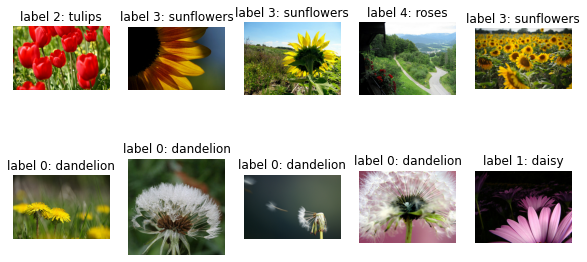

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

이미지를 같은 크기로 formatting 하기

In [92]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = (image/255.0) # 픽셀값의 scale 수정
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


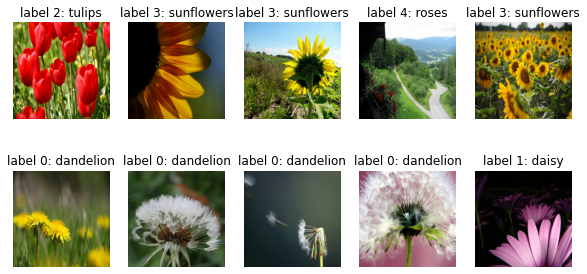

In [93]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

train_batches, validation_batches, test_batches 만들기

In [94]:
# 한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정해주겠습니다.
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# train_batches, validation_batches, test_batches를 만들어 주겠습니다. 
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## Step 3. 모델 설계하기

In [95]:
# basemodel을 활용하여 모델 설계
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG16 활용
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [96]:
base_model.trainable = False

# 모델 정의
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(256, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(128, activation='relu'),  # 추가 레이어
    tf.keras.layers.BatchNormalization(),  # 정규화 레이어 추가
    tf.keras.layers.Dropout(0.5),  # 드롭아웃 레이어 추가
    tf.keras.layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋에서는 class의 갯수가 5가지
])

## Step 4. 모델 학습시키기

In [97]:
# 모델 학습
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches, 
                    epochs=20, # epochs를 20으로 증가
                    validation_data=validation_batches)

Epoch 1/20
92/92 [==============================] - 16s 148ms/step - loss: 1.4771 - accuracy: 0.5089 - val_loss: 1.2961 - val_accuracy: 0.4796
Epoch 2/20
92/92 [==============================] - 13s 140ms/step - loss: 0.9821 - accuracy: 0.6645 - val_loss: 0.8823 - val_accuracy: 0.7330
Epoch 3/20
92/92 [==============================] - 13s 141ms/step - loss: 0.8273 - accuracy: 0.7013 - val_loss: 0.7410 - val_accuracy: 0.7166
Epoch 4/20
92/92 [==============================] - 13s 142ms/step - loss: 0.7483 - accuracy: 0.7418 - val_loss: 0.5551 - val_accuracy: 0.7711
Epoch 5/20
92/92 [==============================] - 13s 143ms/step - loss: 0.6734 - accuracy: 0.7752 - val_loss: 0.5204 - val_accuracy: 0.8065
Epoch 6/20
92/92 [==============================] - 14s 144ms/step - loss: 0.6078 - accuracy: 0.7803 - val_loss: 0.5137 - val_accuracy: 0.8229
Epoch 7/20
92/92 [==============================] - 14s 145ms/step - loss: 0.5719 - accuracy: 0.7980 - val_loss: 0.5006 - val_accuracy: 0.7929

## Step 5. 모델 성능 평가하기

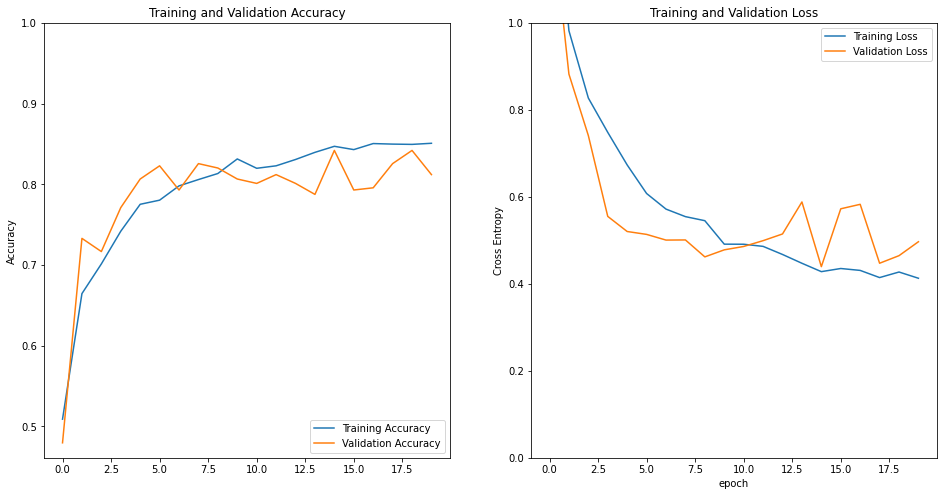

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [99]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[4.23209695e-03, 1.00826202e-02, 9.08048272e-01, 2.43164897e-02,
        5.33205606e-02],
       [9.99576628e-01, 2.19597612e-04, 6.51073569e-05, 3.06966685e-05,
        1.07903055e-04],
       [3.22442234e-01, 1.28176719e-01, 1.83520839e-02, 5.26562274e-01,
        4.46665194e-03],
       [2.91120698e-04, 5.85156842e-04, 8.78482819e-01, 6.01677457e-04,
        1.20039247e-01],
       [8.71675074e-01, 1.07909106e-01, 1.30869150e-02, 1.80338428e-03,
        5.52536966e-03],
       [9.95381474e-01, 1.92145118e-03, 2.31194848e-04, 2.13335711e-03,
        3.32602940e-04],
       [1.40046880e-01, 1.62357718e-01, 3.66897881e-01, 4.22387794e-02,
        2.88458705e-01],
       [2.22965293e-02, 8.94091308e-01, 8.50993209e-04, 8.10056180e-02,
        1.75558717e-03],
       [9.88887768e-05, 3.00278271e-06, 3.74879572e-04, 9.99394417e-01,
        1.28831802e-04],
       [9.99272764e-01, 6.74755196e-04, 2.00461927e-05, 1.37581401e-05,
        1.87521200e-05],
       [9.85351980e-01, 1.1034

In [100]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 3, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

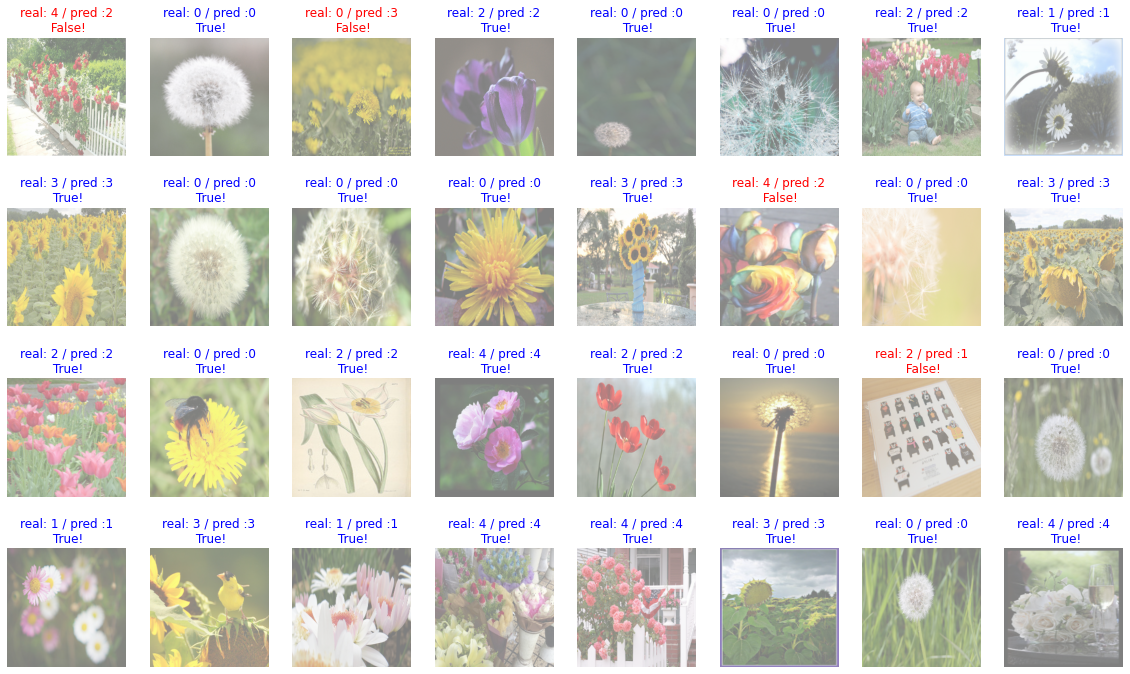

In [101]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [102]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100)

87.5
